# Introduction to Backtesting: Part 1

Following from our *Introduction to Algorithmic Trading*, let us have a look at how our understanding of technical indicators can be used to create trading strategies. In this two-part series, we're going to cover a lot of material. We shall look at:

- Initial Setup
- Algorithmic Trading Strategies
- Vectorised Back-testing
  - Motivation
  - Building a strategy
  - Testing our strategy
  - Using Machine Learning
    - Logistic Regression
    - Deep Neural Networks
  
In Part 1, we will look at Vectorised Back-testing. We will explore content for Event-driven backtesting in Part 2.

## Initial Setup

Let's start by setting up some of the key functions we need for our discussion of vectorised backtesting. These are borrowed from our first notebook, *Introduction to Algorithmic Trading*.

In [1]:
import PlaygroundData.FixerData as pdata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_data(args):
    fdrh = pdata.FixerDataRequestHandler()
    data = fdrh.get_data(args)

    data["Date"] = pd.to_datetime(data["Date"])
    data.set_index(
    "Date",
    drop=True,
    inplace=True
    )
    return data
    
def sma(data, n, inplace=False):
    sma = data[f"{FROM_CURR}{TO_CURR}"].rolling(window=n, min_periods=1, center=False).mean()
    if inplace == False:
        return np.array(sma)
    else:
        data[f"sma_{n}"] = sma
        return np.array(sma)

## Algorithmic Trading Strategies

Let us now dive right into it. An **algorithmic trading strategy** will ultimately consist of two things:

- Signal Generators
- Execution Logic

**Signal generators** are algorithms which produce a signal to "act" i.e. to buy or to sell. This could be based on rules which we have programmed, or could be discovered through the action of automated systems such as classification algorithms. In this context, these will often be calculated based on the behaviour of **technical indicators**, but we can expand this definition to include signals generated from any number of statistical models, machine learning models etc.

Our **execution logic** gathers our signals together and decides what ought to be done about them. This forms the core of our trading strategy. Our logic is responsible for deciding which signals should be acted upon, when we should act upon them, and what that action for be. As we will see later, a great deal of our work in **managing risk** will involve carefully written execution logic.

## Vectorised Back-testing

### Motivation

There are generally considered to be two main practical approaches to writing and testing algorithmic trading strategies on historical data: *vectorised* and *event-driven*.

The vectorised approach gets its name from the fact that vector-based operations in **NumPy** and **Pandas** are heavily used for almost all significant computations which are performed. This is a method of performing calculations on large lists of data which uses methods from linear algebra as opposed to iterating through values one at a time. These methods can often be several orders of magnitude faster for performing arithmetic calculaions. 

Here is an example:

In [2]:
# Using Standard Python with loops
import random
import time
start = time.time()
X = []
Y = []
Z = []
for i in range(0, 1000000):
    X.append(random.random())
    Y.append(random.random())
for i in range(len(X)):
    Z.append(X[i] + Y[i]) 
end = time.time()
print(f"Math operation took: {(end - start)}s")

Math operation took: 0.2999992370605469s


In [3]:
# Using Numpy
start = time.time()
X = np.random.rand(1000000, 1)
Y = np.random.rand(1000000, 1)
Z = X + Y
end = time.time()
print(f"Math operation took: {(end - start)}s")

Math operation took: 0.032001495361328125s


The above two cells generate two lists, each containing 1 million random numbers between 0 and 1, add them together, and store in a new list. As we can see, the *vectorised* implementation is over **10 times faster** than the for-loop based calculation, and also much easier to read. As we will see throghout this notebook, vectorised methods are computationally efficient, but can be limiting as we will see in the future.

### Building a Strategy

The first step for building a strategy is to build a signal generator. That is to say, we need to use some model, metric, or tecnhical indicator to decide when we should buy or sell some of our asset. Let's start with something simple. Consider two moving averages, **SMA(n)** and **SMA(m)**, where **n > m**. When these cross over, we have two possibilities - that the short is now greater than the long, or the long is now greater than the short. 

In the first case, this that we have an indication that the price will *increase*; in the second case, we have an indication that the price will *decrease*. If we use a so-called momentum-following principle, this means that we should buy and sell the asset in each case respectively.

In [4]:
def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))

def sma_crossover_signal(data, params, inplace=False):
    # calc SMAs for crossover strategy
    n, m = params[0], params[1]
    short_sma = pd.Series(sma(data, n, inplace=True), index=data.index)
    long_sma = pd.Series(sma(data, m, inplace=True), index=data.index)
    diff = short_sma - long_sma
    # 1 when short is higher than long, otherwise 0
    position = np.where(diff > 0, 1.0, -1.0)
    # shift value to prevent foresight bias by 1 day
    position = shift(position, 1)
    # first difference gives 1 for buy, -1 for sell, add a 0 at the end so lengths match
    signal = np.append(np.diff(position, 1), np.array([0])) / 2.0
    signal = shift(signal, 1)
    # fill nan
    position = np.nan_to_num(position)
    signal = np.nan_to_num(signal)
    if inplace==False:
        return signal, position
    else:
        data[f"sma_{n}"] = short_sma.values
        data[f"sma_{m}"] = long_sma.values
        return signal, position

This code will take our timeseries data and generate two SMAs from it. We calculate the difference between them and use the following logic:

- If SMA(n) > SMA(m), we think the price is going up and we want to have a *long* position in the asset i.e. we want to have some of it
- If SMA(m) <= SMA(n), we think the price is going down and we want to have a *short* position in the asset i.e. we want to sell it

We use 1 and -1 to indicate the position we want to have in each case respectively and store in a list called *positions*. We shift this list by 1 day to take into account that we have to wait until tomorrow to act on the *closing price of today*. Failure to implement this would create foresight bias.

Let's now load up our historical Forex data, and visualise our SMAs:

Attempting to fetch data from SQL database.


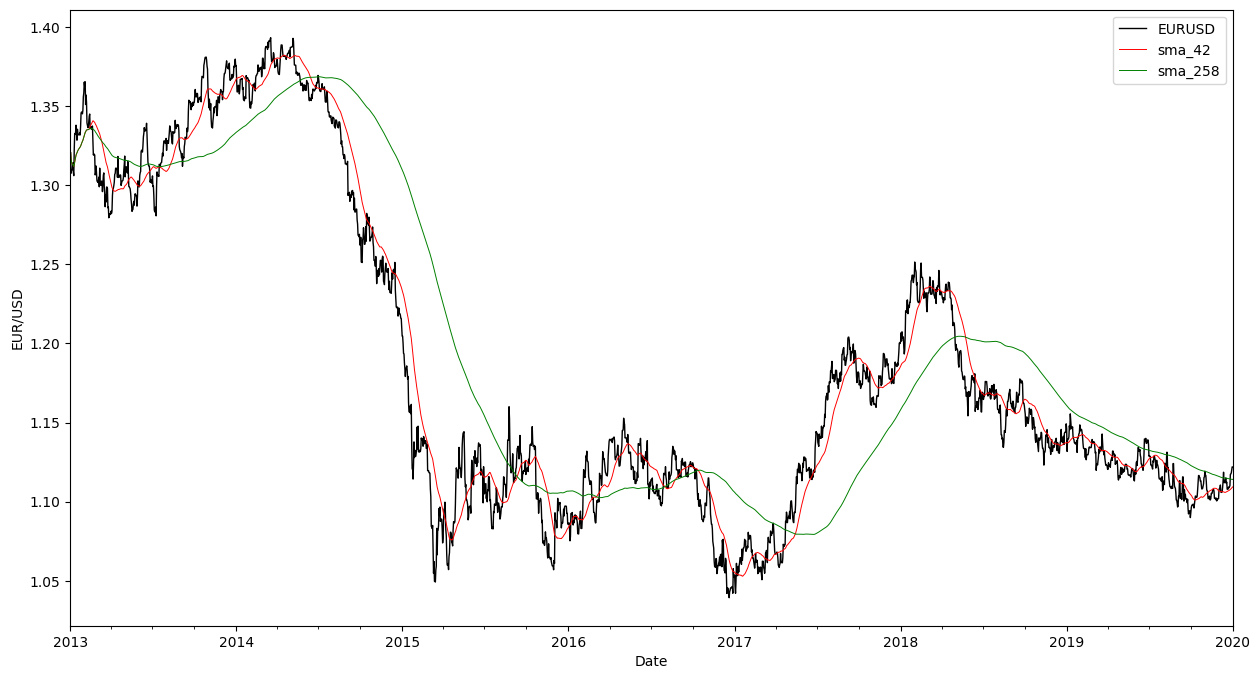

In [5]:
# load data
FROM_CURR = "EUR"
TO_CURR = "USD"
ARGS = {"start_date": "2013-01-01","end_date": "2020-01-01","from_curr": FROM_CURR,"to_curr": TO_CURR}
data = load_data(ARGS)
n = 42
m = 258
signal, position = sma_crossover_signal(data, (n, m), inplace=False)
# plot data
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(111, ylabel=f"{FROM_CURR}/{TO_CURR}")
data[f"{FROM_CURR}{TO_CURR}"].plot(ax=ax1, color='black', lw='1', legend=True)
data[f"sma_{n}"].plot(ax=ax1, color='r', lw='.7', legend=True)
data[f"sma_{m}"].plot(ax=ax1, color='g', lw='.7', legend=True)
plt.show()

We can plot the points where we would change our position i.e. when a signal occurs, as follows:


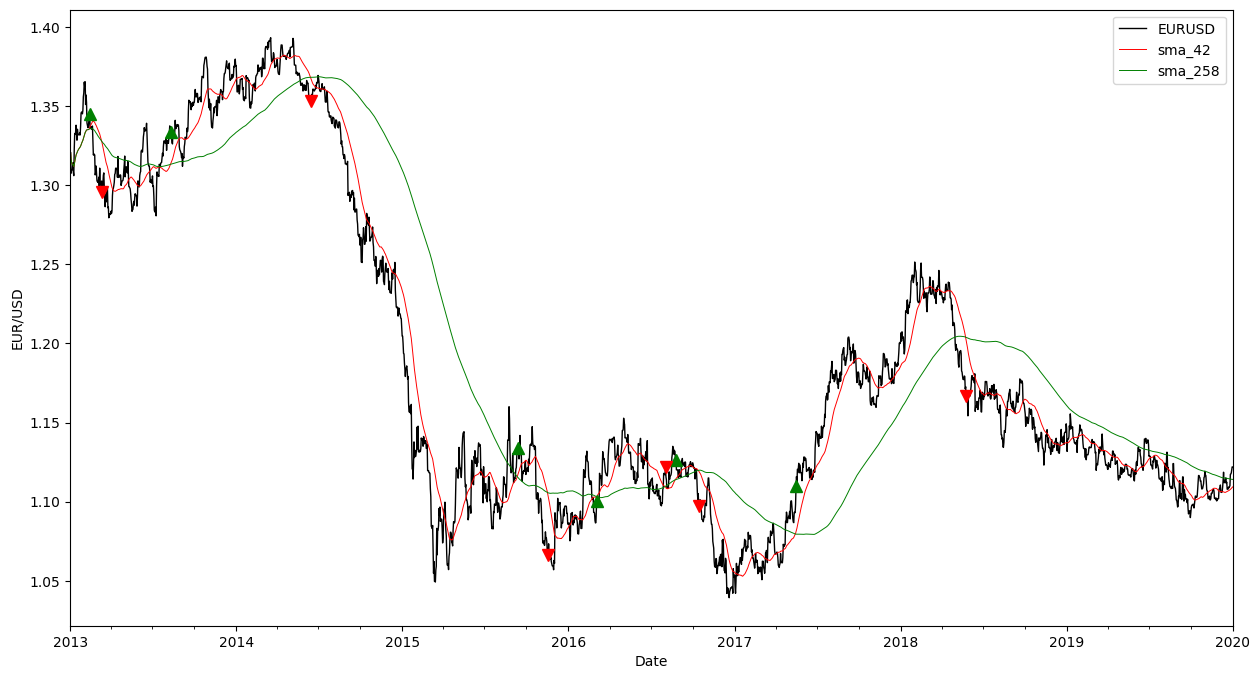

In [6]:
# calculate signal points
data["signal"] = signal
data["position"] = position
long_index = data["signal"][data["signal"] == 1.0].index
short_index = data["signal"][data["signal"] == -1.0].index
# plot data
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(111, ylabel=f"{FROM_CURR}/{TO_CURR}")
data[f"{FROM_CURR}{TO_CURR}"].plot(ax=ax1, color='black', lw='1', legend=True)
data[f"sma_{n}"].plot(ax=ax1, color='r', lw='.7', legend=True)
data[f"sma_{m}"].plot(ax=ax1, color='g', lw='.7', legend=True)
ax1.plot(long_index, data[f"{FROM_CURR}{TO_CURR}"][long_index], '^', markersize=9, color='green')
ax1.plot(short_index, data[f"{FROM_CURR}{TO_CURR}"][short_index], 'v', markersize=9, color='red')
plt.show()

### Testing the Strategy

So, we now have our data, our strategy, and we have a visual sense of the actions our strategy gets us to do. It is now time to figure out how *good* our strategy is. There are several ways we can evaluate a strategy. First, let's consider the following values:

- Log returns
- Strategy returns
- Gross performance
- Net performance

The log returns are the natural logarithm of the asset price divided by its value a day ago. This value gives us the daily returns that can be expected by simply holding the base currency.

In [7]:
# log returns
data['returns'] = np.log( data[f"{FROM_CURR}{TO_CURR}"] / data[f"{FROM_CURR}{TO_CURR}"].shift(1) )

The strategy returns are just the asset returns multiplied by our position vector:

In [8]:
# strategy returns
data['strat_returns'] = data['position'] * data['returns']

These are still logarithmic values. If we apply *e^x* to each of these values and add them up, we get the total returns of our asset and of our strategy. After converting to percentages, we have the following:

In [9]:
# strategy returns
(data[['returns', 'strat_returns']].sum().apply(np.exp) - 1) * 100

returns         -15.060432
strat_returns    11.073770
dtype: float64

Great news!. If we start with n euros at 2015-01-01, it would be worth 15% less in USD if we did absolutely nothing with it, but if we use our strategy we will end up with 11% more. 

Looking at our returns over time shows us the following:

<AxesSubplot: xlabel='Date'>

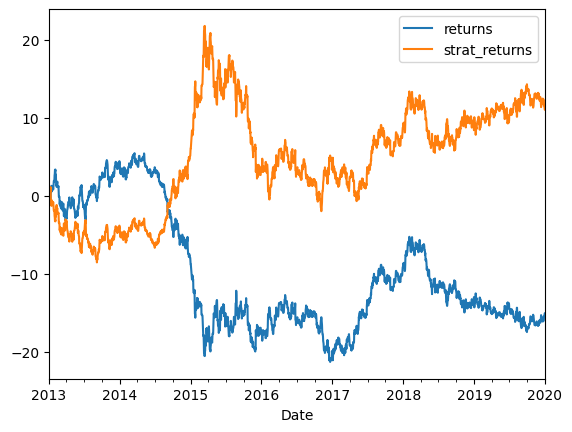

In [10]:
((data[['returns', 'strat_returns']].cumsum().apply(np.exp) - 1) * 100).plot()

One significant inaccuracy of our current model is that we haven't taken into consideration transaction costs. Buying and selling on the open market costs money, and these commission amounts can quickly add up for strategies which execute a large number of trades.

The strategy we have executes the following number of trades:

In [11]:
# trade count
total_trades = sum(data['position'].diff() != 0) + 2 #includes entry and exit trade to close out positions
total_trades

16

We can add transaction costs to our strategy returns in the following way:

In [12]:
# commission percentage
c = 0.005
# adjust strategy returns for commission
data['adj_strat_returns'] = np.where(data['position'].diff() != 0, data['strat_returns'] - c, data['strat_returns'])
# adjust the first and last trades
data['adj_strat_returns'].iloc[0] -= c
data['adj_strat_returns'].iloc[-1] -= c


Now, we can look at our adjusted strategy performance:

In [13]:
(data[['returns', 'strat_returns', 'adj_strat_returns']].sum().apply(np.exp) - 1) * 100

returns             -15.060432
strat_returns        11.073770
adj_strat_returns     3.564497
dtype: float64

<AxesSubplot: xlabel='Date'>

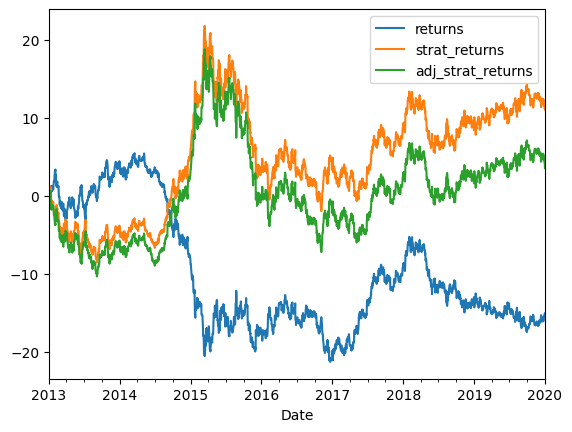

In [14]:
((data[['returns', 'strat_returns', 'adj_strat_returns']].cumsum().apply(np.exp) - 1) * 100).plot()

Clearly, our commission adjusted strategy still performs well, especially over simply doing nothing and holding onto the base currency. However, we can see that our adjusted returns are significantly lower. This effect only increases for strategies which make more trades, and so we need to be careful not just to make good trades, but to find the very best ones to maximise our returns.

Play around with the lag values for the SMAs to see how this affects our returns.

## Using Machine Learning

At this stage, you could imagine being able to use different technical indicators or combinations of these to produce signals, and use these to produce trading signals. However, more signals means more complexity, and it can become even harder to know which ones are important for knowing whether or not our returns would be positive or negative tomorrow.

This ultimately boils down to a *binary classification* problem, and is a great fit for using a *supervised learning* approach to attempt to predict from several technical indicators whether or not our returns are going to be positive or negative.

First, let's reload our dataset and add use this to generate several different technical indicators:. In this case, we're going to use:

- Daily return
- Simple moving average
- Maximum Value
- Minimum Value
- Momentum
- Volatility

In [15]:
# helper function for loading several technical indicators at once
def add_features(data, sym, lags, window):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    # caalculate features
    df['return'] = np.log(df / df.shift(1))
    df[f'sma_{window}'] = df[sym].rolling(window).mean()
    df['max'] = df[sym].rolling(window).max()
    df['min'] = df[sym].rolling(window).min()
    df['momentum'] = df['return'].rolling(window).mean()
    df['volat'] = df['return'].rolling(window).std()
    df.dropna(inplace=True)
    df['label'] = np.where(df['return'] > 0, 1, 0)
    features = [sym, 'return', f'sma_{window}', 'max', 'min', 'momentum', 'volat']
    # produce lagged versions of each feature
    for f in features:
        for l in range(1, lags+1):
            col = f'{f}_lag_{l}'
            df[col] = df[f].shift(l)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [16]:
# load data from source
FROM_CURR = "EUR"
TO_CURR = "USD"
ARGS = {"start_date": "2013-01-01","end_date": "2022-01-01","from_curr": FROM_CURR,"to_curr": TO_CURR}
source_data = load_data(ARGS)
# enrich data with features
rich_data, cols = add_features(source_data, f'{FROM_CURR}{TO_CURR}', 10, 25)
rich_data

Attempting to fetch data from SQL database.


,EURUSD,return,sma_25,max,min,momentum,volat,label,EURUSD_lag_1,EURUSD_lag_2,...,volat_lag_1,volat_lag_2,volat_lag_3,volat_lag_4,volat_lag_5,volat_lag_6,volat_lag_7,volat_lag_8,volat_lag_9,volat_lag_10
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-05,1.356944,0.004448,1.342983,1.365296,1.32839,7.280900e-04,0.003678,1,1.350922,1.365296,...,0.003841,0.003785,0.003849,0.003975,0.003923,0.003930,0.003803,0.003802,0.004394,0.004395
2013-02-06,1.352115,-0.003565,1.343780,1.365296,1.32839,5.938632e-04,0.003774,0,1.356944,1.350922,...,0.003678,0.003841,0.003785,0.003849,0.003975,0.003923,0.003930,0.003803,0.003802,0.004394
2013-02-07,1.339221,-0.009582,1.344007,1.365296,1.32839,1.693218e-04,0.004285,0,1.352115,1.356944,...,0.003774,0.003678,0.003841,0.003785,0.003849,0.003975,0.003923,0.003930,0.003803,0.003802
2013-02-08,1.337719,-0.001122,1.344001,1.365296,1.32839,-4.126214e-06,0.004244,0,1.339221,1.352115,...,0.004285,0.003774,0.003678,0.003841,0.003785,0.003849,0.003975,0.003923,0.003930,0.003803
2013-02-09,1.336350,-0.001024,1.344174,1.365296,1.32839,1.292466e-04,0.004153,0,1.337719,1.339221,...,0.004244,0.004285,0.003774,0.003678,0.003841,0.003785,0.003849,0.003975,0.003923,0.003930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28,1.131358,-0.001357,1.130021,1.134436,1.12381,4.949834e-07,0.002947,0,1.132894,1.132362,...,0.002936,0.002945,0.002937,0.003015,0.003005,0.003047,0.002953,0.003544,0.003494,0.003574
2021-12-29,1.135957,0.004057,1.130205,1.135957,1.12381,1.627664e-04,0.003057,1,1.131358,1.132894,...,0.002947,0.002936,0.002945,0.002937,0.003015,0.003005,0.003047,0.002953,0.003544,0.003494
2021-12-30,1.132375,-0.003158,1.130285,1.135957,1.12381,7.017964e-05,0.003123,0,1.135957,1.131358,...,0.003057,0.002947,0.002936,0.002945,0.002937,0.003015,0.003005,0.003047,0.002953,0.003544


Here is our feature generator applied to our data source using 10 different lags and a window of size 25.

You might notice some features from above that you're not familar with, such as momentum and volatility. These are extremely useful technical indicators, the first being the moving average of the returns, and the second being their standard deviation. Our label is a simple binary value, showing whether or not the returns were positive or negative. Notice that for each of these features, we produced lagged copies of these to try to give our model as much information as possible. 

#### Logistic Regression

The question now remains: *which Machine Learning model should we use?* There are more options for this than are worth listing here, so lets try a couple. For a first example, let's try one of the most simple models: Logistic Regression.


We will produce a train-test split of the dataset and use this to train a Logistic Regression model. We can then use this to produce positions and see how it works as a trading strategy.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# train/test
split = '2021-01-01'
train_data = rich_data.loc[:split].copy()
test_data = rich_data.loc[split:].copy()
# puts label as first column, useful later
train_data = train_data[ ['label']+[col for col in list(train_data.columns) if col != 'label'] ]
test_data = test_data[ ['label']+[col for col in list(train_data.columns) if col != 'label'] ]
X_train = train_data.drop(columns='label')
Y_train = train_data['label']
X_test = test_data.drop(columns='label')
Y_test = test_data['label']

In [18]:
# train model
lg = LogisticRegression(random_state=1)
lg.fit(X_train, Y_train)

# evaluate on a prediction set
Y_pred = lg.predict(X_test)

acc = metrics.mean_squared_error(Y_test, Y_pred)
acc * 100

45.08196721311475

We have a mean squared error of around 42% on our test data, which is honestly not fantastic. Let's see how well this model works for our trading strategy *in-sample*. The main change from our earlier work is that our position now comes from our model prediction as follows:

In [19]:
def vector_backtest_scikit(data, cols, model):
    df = data.copy()
    df['position'] = np.where(model.predict(df > 0.5), 1, 0)
    df['position'] = np.where(df['position'] == 1, 1, -1)
    df['strat_return'] = df['position'] * df['return']
    df_strat_summary = (df[['return', 'strat_return']].sum().apply(np.exp) -1) * 100
    df_strat = ( df[['return', 'strat_return']].cumsum().apply(np.exp) -1) * 100
    return df_strat, df_strat_summary

In [20]:
in_strat, in_strat_summary = vector_backtest_scikit(X_train, cols, lg)
in_strat_summary

return          -9.87074
strat_return    10.95176
dtype: float64

<AxesSubplot: xlabel='Date'>

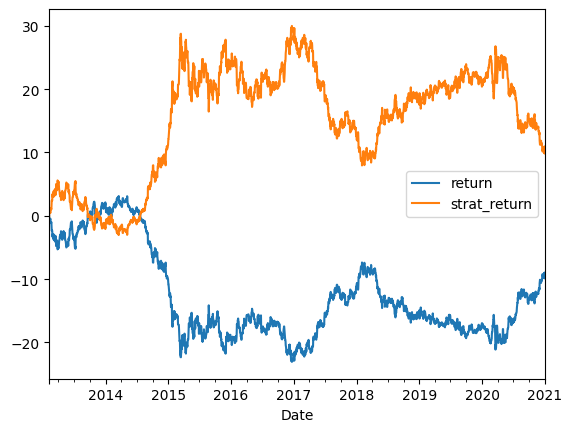

In [21]:
in_strat.plot()

Despite our so-so model performance, when applied to our use-case of backtesting, the results look fantastic! However, we need to test our model on *out-of-sample-data* to truly know if it is any good:

In [22]:
out_strat, out_strat_summary = vector_backtest_scikit(X_test, cols, lg)
out_strat_summary

return         -6.628759
strat_return    7.099358
dtype: float64

<AxesSubplot: xlabel='Date'>

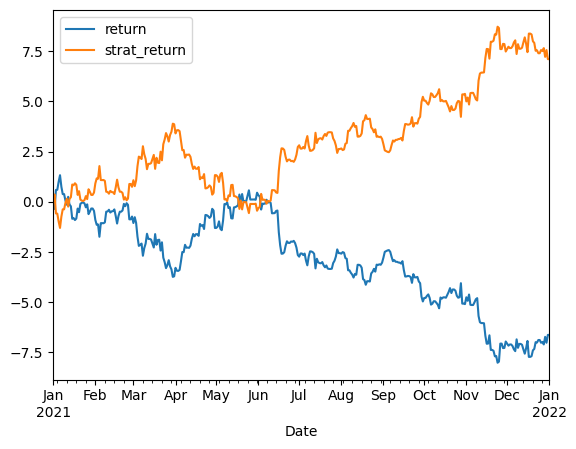

In [23]:
out_strat.plot()

As expected, the ability our model has a much more modest performance on out-of-sample data, and this is what we are actually interested in. Logistic regression are extremely simple models. Let's now look at something a bit more involved.

### Deep Neural Network (DNN)

At the far end of the complexity scale, we have Deep Neural Networks. These are deeply nested combinations of regression models which can be augmented in various ways to improve their performance e.g. Convolutional Neural Networks, Recurrent Neural Networks.

We will look at a simple example of applying a DNN to time series data, but note that this is just scratching the very surface of this topic. This is a very active research area in modern times.

We will be using TensorFlow to build a DNN here and then seeing how effective it can be for our trading problem!

In order to use TensorFlow, we're going to have to build our training data into a *TensorFlow dataset*. TensorFlow contains many options for data preprocessing, including steps which allow us to easily produce lagged datasets.

In [24]:
import tensorflow as tf

# Reset states generated by Keras
tf.keras.backend.clear_session()

# make tf datasets
def get_tf_dataset(X, Y):
    # convert training data to numpy arrays
    np_x = X.to_numpy()
    np_y = Y.to_numpy()
    # expand dims
    np_x = np.expand_dims(np_x, axis=-2)
    np_y = np.expand_dims(np_y, axis=-1)
    # normalise data
    mean, std = np.mean(np_x, axis=0), np.std(np_x, axis=0)
    np_x = (np_x - mean) / std
    # make Tensorflow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((np_x, np_y))
    # cache values
    normal_cache = {'mean': mean, 'std': std}
    return dataset, normal_cache

train_dataset, normal_cache= get_tf_dataset(X_train, Y_train)

Our data is now ready for use in Tensorflow. We're going to start with a simple model:

- An input layer with a single node, using a "Leaky ReLU" activation 
- Two hidden layers, each one with 2 nodes and a sigmoid activation
- A single output node with a sigmoid activation.

We shall also use an Early Stopping procedure, use *Adam* as an optimiser, and measure performance using Mean Squared Error:

In [147]:
def create_model(h_layers, units, dropout=False, optim=None, loss=None, metrics=None):
    model = tf.keras.models.Sequential([])
    
    model.add(tf.keras.layers.Dense(units[0], activation='leaky_relu'))
    for i in range(0, h_layers):
        model.add(tf.keras.layers.Dense(units[i], activation='sigmoid'))
        if dropout:
            model.add(tf.keras.layers.Dropout(rate = 0.2))
    model.add(tf.keras.layers.Dense(units[-1], activation='relu'))
    model.compile(loss=loss, metrics=[loss], optimizer=optim)
    return model
    
model = create_model(
    h_layers=4,
    dropout=False,
    units = [1, 2, 2, 1],
    optim = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['mean_squared_error']
)
e_stop = tf.keras.callbacks.EarlyStopping(monitor='mean_squared_error', patience=5)

Let's fit the model:

In [148]:
history = model.fit(train_dataset, epochs=30, callbacks=[e_stop])

Epoch 1/30
2888/2888 [==============================] - 3s 736us/step - loss: 0.2463 - mean_squared_error: 0.2463
Epoch 2/30
2888/2888 [==============================] - 2s 741us/step - loss: 0.2407 - mean_squared_error: 0.2407
Epoch 3/30
2888/2888 [==============================] - 2s 729us/step - loss: 0.1927 - mean_squared_error: 0.1927
Epoch 4/30
2888/2888 [==============================] - 2s 733us/step - loss: 0.0825 - mean_squared_error: 0.0825
Epoch 5/30
2888/2888 [==============================] - 2s 742us/step - loss: 0.0394 - mean_squared_error: 0.0394
Epoch 6/30
2888/2888 [==============================] - 2s 742us/step - loss: 0.0339 - mean_squared_error: 0.0339
Epoch 7/30
2888/2888 [==============================] - 2s 747us/step - loss: 0.0353 - mean_squared_error: 0.0353
Epoch 8/30
2888/2888 [==============================] - 2s 776us/step - loss: 0.0354 - mean_squared_error: 0.0354
Epoch 9/30
2888/2888 [==============================] - 2s 816us/step - loss: 0.0329 - m

We can now use a similar process to our Logistic Regression model to see how well this model performs *out-of-sample*:

In [149]:
def get_forecast(X_test, model):
    # get numpy array
    np_x = X_test.to_numpy()
    # expand dims
    np_x = np.expand_dims(np_x, axis=-2)
    # normalise input
    np_x = (np_x - normal_cache['mean']) / normal_cache['std']
    # get dataset
    dataset = tf.data.Dataset.from_tensor_slices(np_x)
    # get forecast
    pred = model.predict(dataset)
    return pred

def vector_backtest_tf(data, cols, model):
    df = data.copy()
    pred = get_forecast(data, model)
    df['position'] = np.where((pred > 0.5), 1, 0)
    df['position'] = np.where(df['position'] == 1, 1, -1)
    df['strat_return'] = df['position'] * df['return']
    df_strat_summary = (df[['return', 'strat_return']].sum().apply(np.exp) -1) * 100
    df_strat = ( df[['return', 'strat_return']].cumsum().apply(np.exp) -1) * 100
    return df_strat, df_strat_summary

In [150]:
strat, summary = vector_backtest_tf(X_test, cols, model)
summary

366/366 [==============================] - 0s 508us/step


return           -6.628759
strat_return    114.868206
dtype: float64

<AxesSubplot: xlabel='Date'>

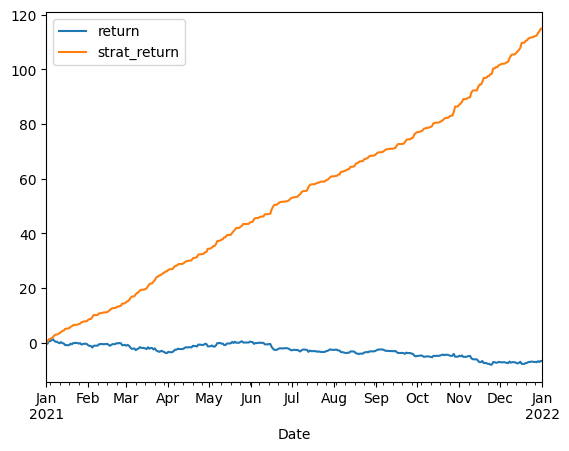

In [151]:
strat.plot()

Behold! With the power of our very simple DNN, we have been able to go from a -6% baseline return to a **114% return when using our strategy!** 

Just as a quick sense check, let's add back our trading commission costs and see how our model performs under more realistic conditions.

In [152]:
import warnings
warnings.filterwarnings("ignore")
def vector_backtest_tf_with_commission(data, cols, model, commission=0.005):
    c = commission
    df = data.copy()
    pred = get_forecast(data, model)
    df['position'] = np.where((pred > 1-0.5), 1, 0)
    df['position'] = np.where(df['position'] == 1, 1, -1)
    df['strat_return'] = df['position'] * df['return']
    # adjust strategy returns for commission
    df['adj_strat_return'] = np.where(df['position'].diff() != 0, df['strat_return'] - c, df['strat_return'])
    # adjust the first and last trades
    df['adj_strat_return'].iloc[0] -= c
    df['adj_strat_return'].iloc[-1] -= c
    df_strat_summary = (df[['return', 'strat_return', 'adj_strat_return']].sum().apply(np.exp) -1) * 100
    df_strat_summary['total_trades'] = sum(df['position'].diff() != 0) + 2
    df_strat = ( df[['return', 'strat_return', 'adj_strat_return']].cumsum().apply(np.exp) -1) * 100
    return df_strat, df_strat_summary



In [153]:
strat, summary = vector_backtest_tf_with_commission(X_test, cols, model, commission=0.005)
summary

366/366 [==============================] - 0s 544us/step


return               -6.628759
strat_return        114.868206
adj_strat_return    -16.485118
total_trades        189.000000
dtype: float64

<AxesSubplot: xlabel='Date'>

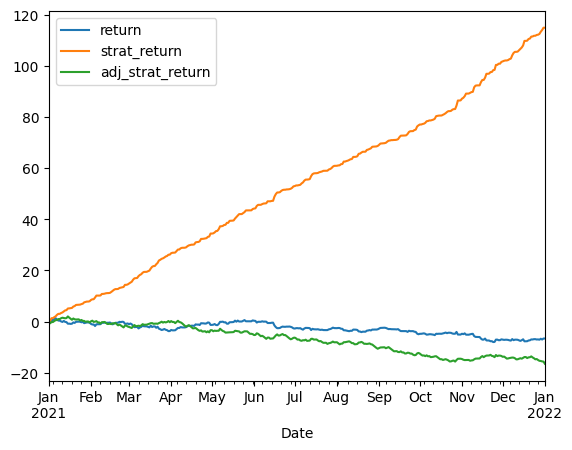

In [154]:
strat.plot()

Even with adjustments for trading commissions, we can see that our model still leads to a 95% return over a year, executing 187 trades during this period. What a great result!